**You Wu**

#Perder hasta la camisa

En este problema trabajaremos con datos reales del NASDAQ sobre la cotización de las acciones de cinco empresas tecnológicas (Google, Microsoft, Apple, Intel y AMD) durante cinco años.

In [1]:
!pip install --user --upgrade apafib --quiet
!pip install scikit_optimize --quiet
!pip install sklearn --quiet

In [2]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, \
                    mean_squared_error, make_scorer, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit

from skopt import BayesSearchCV

from IPython.display import display, HTML

# import warnings

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df


In [4]:
from apafib import load_NASDAQ

data = load_NASDAQ()

In [5]:
data

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
0,45.3330,18846560,0.4800,72.15,17698800,0.78,39.3025,105320280,0.6950,34.92,26479700,0.580,12.05,58786300,0.5600
1,46.2345,23326400,0.7192,73.16,14333220,0.89,39.9450,86259560,0.4950,34.65,26093400,0.570,12.17,38946780,0.2300
2,46.3500,21771500,0.5285,72.72,13758650,0.62,39.9950,77507760,0.3975,34.66,19775620,0.430,12.48,44193270,0.5850
3,46.0640,25323820,0.7670,72.69,17097240,0.79,39.8175,79128680,0.5475,34.71,14283180,0.340,12.50,37161680,0.3200
4,45.7945,21055280,0.5027,72.82,12790300,0.87,39.9650,100738400,0.3225,34.67,14714810,0.350,12.43,29650370,0.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,122.8800,15524950,1.6900,293.47,18085650,4.07,173.1900,54091690,2.0450,36.34,25400550,0.720,101.01,61327140,2.0498
1255,122.5100,15626170,1.6926,292.71,18102880,3.62,173.0300,56377050,2.0482,36.19,25000240,0.875,100.20,60220670,3.1299
1256,120.3200,17589160,1.9500,291.32,18253360,3.88,174.5500,79542040,3.5800,35.78,29176060,0.805,98.27,63735580,2.9150
1257,120.8600,15652030,2.1398,290.17,17186190,2.83,174.1500,62290080,1.7800,36.20,24598230,0.760,100.44,76059520,4.3358


El conjunto de datos obtenidos són la cotización de las acciones
de cinco empresas tecnológicas (Google, Microsoft, Apple, Intel y AMD).
El valor final de la acción al final del día (P), el volumen de acciones que se intercambiaron (V) y la diferencia entre el mayor y el menor precio al que cotizaron en el día (GAP).


##Apartado A
Primero de todo vamos a ver las características del conjunto de datos dado.


In [6]:
data.describe(include='all')

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
count,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,82.353323,3.091715e+07,1.740178,181.820564,2.953929e+07,3.812815,90.350676,1.184749e+08,2.068242,50.894599,2.900960e+07,1.216749,56.722025,6.915626e+07,2.409231
std,32.320527,1.347789e+07,1.209965,78.621047,1.299424e+07,2.912805,46.269086,5.504025e+07,1.694044,6.684044,1.464157e+07,0.739385,38.704107,3.595598e+07,2.177979
min,45.333000,6.935060e+06,0.238000,72.150000,7.425603e+06,0.340000,35.547500,4.099995e+07,0.213500,34.520000,6.313179e+06,0.210000,9.530000,1.103576e+07,0.120000
25%,56.103500,2.256946e+07,0.871300,108.150000,2.125149e+07,1.660000,47.482500,8.193916e+07,0.776250,46.720000,1.978076e+07,0.760000,21.665000,4.331598e+07,0.820000
50%,67.365000,2.773012e+07,1.371000,163.490000,2.629290e+07,3.060000,71.932500,1.042700e+08,1.502500,50.590000,2.584577e+07,1.026500,48.210000,5.859729e+07,1.720000
75%,112.941500,3.531136e+07,2.218750,252.485000,3.374066e+07,5.141250,133.640000,1.382814e+08,2.925000,55.380000,3.400318e+07,1.450000,87.095000,8.561404e+07,3.295000
max,150.709000,1.238938e+08,9.215500,343.110000,1.109450e+08,23.640000,182.010000,4.268848e+08,12.810000,68.470000,1.822699e+08,8.620000,161.910000,3.238445e+08,15.900000


Examinamos el número de valores NAs para cada variables, obtenimos el resultado en el que todos ellos estan asignados a un valor. 

In [7]:
data.isna().sum()

GOOGLE-P      0
GOOGLE-V      0
GOOGLE-GAP    0
MSFT-P        0
MSFT-V        0
MSFT-GAP      0
AAPL-P        0
AAPL-V        0
AAPL-GAP      0
INTEL-P       0
INTEL-V       0
INTEL-GAP     0
AMD-P         0
AMD-V         0
AMD-GAP       0
dtype: int64

Para estudiar mejor las tres columnas de las empresas vamos analizar-las de manera separada. 

In [8]:
P = data[['GOOGLE-P','MSFT-P', 'AAPL-P', 'INTEL-P', 'AMD-P']].copy()
P.describe(include='all')

,GOOGLE-P,MSFT-P,AAPL-P,INTEL-P,AMD-P
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,82.353323,181.820564,90.350676,50.894599,56.722025
std,32.320527,78.621047,46.269086,6.684044,38.704107
min,45.333000,72.150000,35.547500,34.520000,9.530000
25%,56.103500,108.150000,47.482500,46.720000,21.665000
50%,67.365000,163.490000,71.932500,50.590000,48.210000
75%,112.941500,252.485000,133.640000,55.380000,87.095000
max,150.709000,343.110000,182.010000,68.470000,161.910000


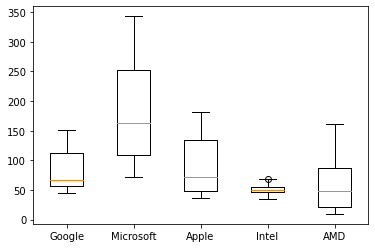

In [9]:
fig, ax = plt.subplots()

boxplot_data = [P['GOOGLE-P'],P['MSFT-P'], P['AAPL-P'], P['INTEL-P'], P['AMD-P']]
ax.boxplot(boxplot_data, labels=['Google','Microsoft','Apple','Intel','AMD']);


En observar el valor final de la acción al final del día(P) de los cinco empresas tecnológicas, podemos ver la empresa Microsoft es el tiene mejor promedio comparando conlas restas de empresas, y Intel es el que tiene menos promedio del valor final de la acción al final del día. 

In [10]:
V = data[['GOOGLE-V','MSFT-V', 'AAPL-V', 'INTEL-V', 'AMD-V']].copy()
V.describe(include='all')

,GOOGLE-V,MSFT-V,AAPL-V,INTEL-V,AMD-V
count,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03
mean,3.091715e+07,2.953929e+07,1.184749e+08,2.900960e+07,6.915626e+07
std,1.347789e+07,1.299424e+07,5.504025e+07,1.464157e+07,3.595598e+07
min,6.935060e+06,7.425603e+06,4.099995e+07,6.313179e+06,1.103576e+07
25%,2.256946e+07,2.125149e+07,8.193916e+07,1.978076e+07,4.331598e+07
50%,2.773012e+07,2.629290e+07,1.042700e+08,2.584577e+07,5.859729e+07
75%,3.531136e+07,3.374066e+07,1.382814e+08,3.400318e+07,8.561404e+07
max,1.238938e+08,1.109450e+08,4.268848e+08,1.822699e+08,3.238445e+08


Todo y que la empresa Apple ha llegado el volumen de acciones que se intercamibaron más alto, es el que tiene el menor promedio comparando con las restas de empresas, y la empresa AMD es el que tiene el mayor promedio de V.

In [11]:
GAP = data[['GOOGLE-GAP','MSFT-GAP', 'AAPL-GAP', 'INTEL-GAP', 'AMD-GAP']].copy()
GAP.describe(include='all')

,GOOGLE-GAP,MSFT-GAP,AAPL-GAP,INTEL-GAP,AMD-GAP
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,1.740178,3.812815,2.068242,1.216749,2.409231
std,1.209965,2.912805,1.694044,0.739385,2.177979
min,0.238000,0.340000,0.213500,0.210000,0.120000
25%,0.871300,1.660000,0.776250,0.760000,0.820000
50%,1.371000,3.060000,1.502500,1.026500,1.720000
75%,2.218750,5.141250,2.925000,1.450000,3.295000
max,9.215500,23.640000,12.810000,8.620000,15.900000


Como podemos observar, la empresa Intel es la que mantiene el precio de cotización en este cinco años más estable, y en cambio la empresa Microsft el menos estable.

A continuación vamos representar de distintas formas la correlación de los datos

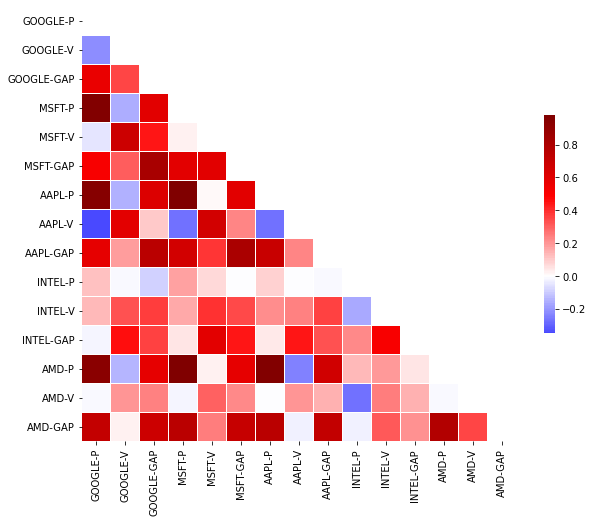

In [12]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

En la matriz de correlaciones entre todas las variables del conjunto de datos podemos observar que existe una relación entre un gran parte de los variables. 

Para analizarlo mejor si existe alguna correlación importante, vamos crear una matriz de correlación para cada acción de las cincos empresas tecnológicas.

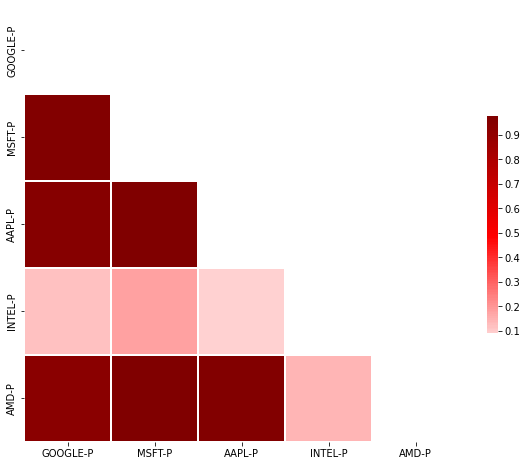

In [13]:
corr_P = P.corr()
mask = np.triu(np.ones_like(corr_P, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_P, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

En el matriz anterior podemos observar existe una relación importante sobre el valor final de la acción al final del día entre las empresas Google, Microsoft, Apple y AMD (alreledor de 0.8 y 0.9), pero para la empresa Intel, no hay niguna relación importante con otras de empresas(entre 0.1 y 0.3).

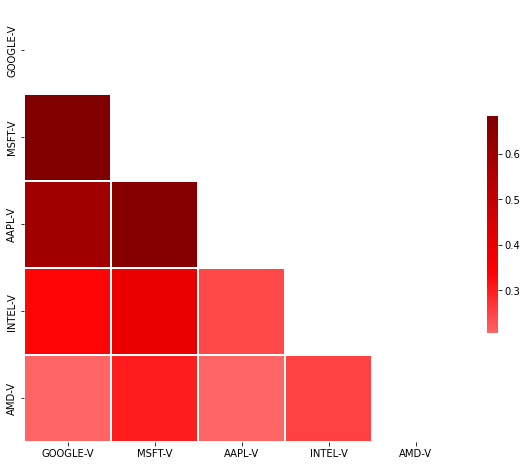

In [14]:
corr_V= V.corr()
mask = np.triu(np.ones_like(corr_V, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_V, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

En cuando para el volumen de acciones que se intercambiaron, las empresas que estan relacionados són Microsoft y Apple su correlación és entre 0.5 y 0.6.

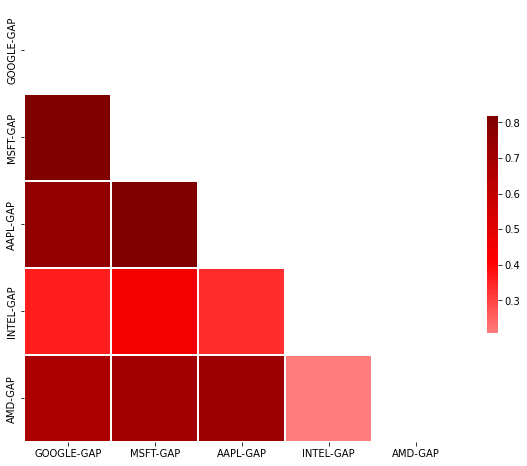

In [15]:
corr_GAP = GAP.corr()
mask = np.triu(np.ones_like(corr_GAP, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_GAP, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Los resultados que obtenemos para GAP són efectivamente satisfactibles, existe una correlación superior al 0.5 excepto la correlación entre AMD-GAP y INTEL-GAP la correlación es aproximadamente de 0.2.

A partir de las correlaciones observado anteriormente creo que es possible predecir la acción GAP de una empresa con el GAP de las restas de empresas.

**Generalización de datos**

A continuación vamos a dividir los datos en conjunto de entrenamineto que seran los 1000 primeros filas(días), y los restos en conjunto de test.

In [16]:
train, test =  data.iloc[:1000], data.iloc[1000:]
train, test

(     GOOGLE-P  GOOGLE-V  GOOGLE-GAP  MSFT-P    MSFT-V  MSFT-GAP    AAPL-P  \
 0     45.3330  18846560      0.4800   72.15  17698800    0.7800   39.3025   
 1     46.2345  23326400      0.7192   73.16  14333220    0.8900   39.9450   
 2     46.3500  21771500      0.5285   72.72  13758650    0.6200   39.9950   
 3     46.0640  25323820      0.7670   72.69  17097240    0.7900   39.8175   
 4     45.7945  21055280      0.5027   72.82  12790300    0.8700   39.9650   
 ..        ...       ...         ...     ...       ...       ...       ...   
 995  136.0285  16527140      1.1230  286.51  16191300    2.9383  146.9500   
 996  136.9400  11871780      1.3500  289.52  13900170    3.5300  147.0600   
 997  137.0360  13565020      1.0335  289.46  16589340    1.8762  146.1400   
 998  138.0020  12379560      1.8927  288.33  16117630    3.7400  146.0900   
 999  138.0965  16039080      1.3250  286.44  18616580    4.0500  145.6000   
 
         AAPL-V  AAPL-GAP  INTEL-P   INTEL-V  INTEL-GAP   AMD-

Utilizando MinMaxScaler escalamos los datos en escala [0,1].

In [17]:
sdscaler = MinMaxScaler()
e_train_s = sdscaler.fit_transform(train.to_numpy())
e_test_s = sdscaler.fit_transform(test.to_numpy())

In [18]:
from numpy.lib.stride_tricks import sliding_window_view

Generamos el conjunto de datos usando todas las variables para una longitud de ventana de 3, y la variable que queremos predecir si el valor del precio de Google subió o bajó respecto al día anterior.

In [19]:
w = 3
e_train_s = sdscaler.fit_transform(train.to_numpy())
print(e_train_s.shape)
windows_train = sliding_window_view(e_train_s, w+1, axis=0).copy()
(x,y,z) = windows_train.shape
X_train_w  = windows_train.squeeze()[:,:,:-1]
(x,y,z) = X_train_w.shape
X_train_w = X_train_w.reshape(x,y*z)
X_train_w.shape
google_P = windows_train.squeeze()[:,:,-1][:,0]
y_train_w = ((google_P > X_train_w[:,2]).astype(int))

(1000, 15)


In [20]:
e_test_s = sdscaler.fit_transform(test.to_numpy())
windows_test = sliding_window_view(e_test_s, w+1, axis=0).copy()
X_test_w  = windows_test.squeeze()[:,:,:-1]
(x,y,z) = X_test_w.shape
X_test_w = X_test_w.reshape(x,y*z)
google_P = windows_test.squeeze()[:,:,-1][:,0]
y_test_w = (google_P > X_test_w[:,2]).astype(int)


In [21]:
X_train_w.shape,X_test_w.shape, y_train_w.shape,y_test_w.shape

((997, 45), (256, 45), (997,), (256,))

#Apartado B
En este apartado vamos a utilizar el modelo de la regresión logística 

In [22]:
niter = 15
CV = 5

##Regresión logística

In [23]:
lr = LogisticRegression(max_iter=1000)

En Regresión Logística si tenemos de hiperparámetros que exploraremos para utilizar los que mejores resultados nos proporcionen. Una vez tengamos estos hiperparámetros, los aplicaremos a nuestro modelo y veremos que porcentaje de acierto obtenemos con el conjunto de test.

In [24]:
param = {'penalty':['l2', 'none'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_bs =  BayesSearchCV(lr,param,cv=CV, n_iter=niter, n_jobs=-1, refit=True,random_state=0)
lr_bs.fit(X_train_w, y_train_w);

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [25]:
show_html = lambda html: display(HTML(html))
show_html(pd.DataFrame(lr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
4,"{'C': 0.03162277660168379, 'penalty': 'l2'}",0.552668,1
10,"{'C': 0.03162277660168379, 'penalty': 'l2'}",0.552668,1
13,"{'C': 0.015848931924611134, 'penalty': 'l2'}",0.552658,3
11,"{'C': 0.001995262314968879, 'penalty': 'l2'}",0.551658,4
9,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.543663,5


Puede haber varios valores de hiperparametros que obtengan el mismo resultado, en ese caso elegiriamos cualquiera de entre ellos. 

En este caso podemos ver como usando l2 como penalty y escogiendo un valor de C igual a 0.0316, obtenemos los mejores resultados (acierto del 55,2%).

Coefs:
RangeIndex(start=0, stop=45, step=1)


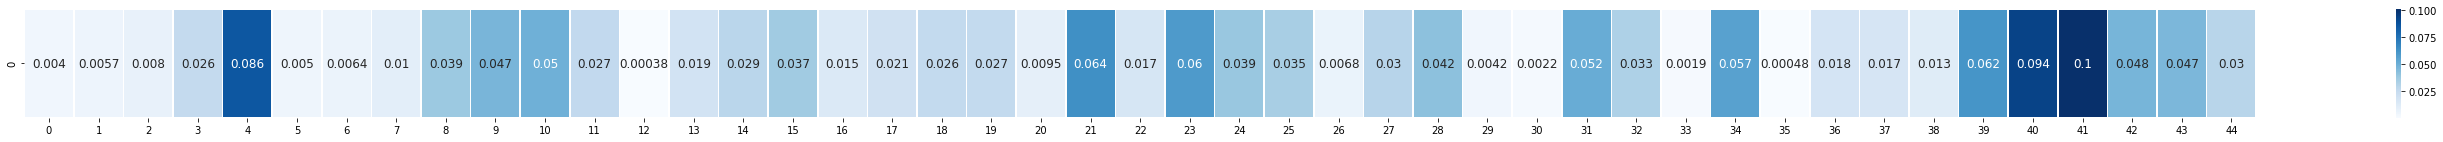

In [26]:
print('Coefs:')
coefs = pd.DataFrame(lr_bs.best_estimator_.coef_)
print(coefs.columns)
plt.figure(figsize=(50,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size':12});

Esta matriz de coeficientes nos indica, para cada variable y clase, lo siguiente. Por cada aumento en una unidad en una de las variables, la clase incremente por el valor del coeficiente, mientras las otras variables se mantienen constantes.

In [27]:
c = lr_bs.best_params_['C']
lr = LogisticRegression(max_iter=1000, C=c)
lr_model = lr.fit(X_train_w, y_train_w)

**Error de la validación cruzada**

In [28]:
print(np.mean(cross_val_score(lr,X_train_w,y_train_w,cv=10)))

0.5526666666666668


Obtenemos la media de la validación cruzada de 0.5526, no es muy satisfecho ya que sólo es un poca más de la mitad.

**Error del test**

In [29]:
print(lr.score(X_test_w,y_test_w))

0.5234375


Con el error del test tambien podemos observar que no se predice de la mayoria satisfecha la variable que queremos predecir, el error de test super el 50%, es decir más de la mitad de las predicciones són incorrectas. 

**Matriz de confusión LR** 

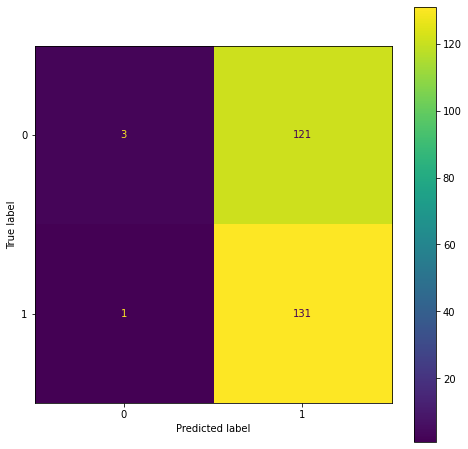

In [30]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_w,y_test_w, display_labels=['0', '1'], ax=plt.subplot());

En la matriz de confusión observamos que casi todos los variables se predice como 1(precio subirá el siguiente día), donde 121 de estas prediciones son falsos, es decir, pretenecen de la clase 0.

**Curva de ROC LR**

El AUC proporciona una medida agregada del rendimiento en todos los umbrales de clasificación posibles. Podemos entender este valor como la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio.



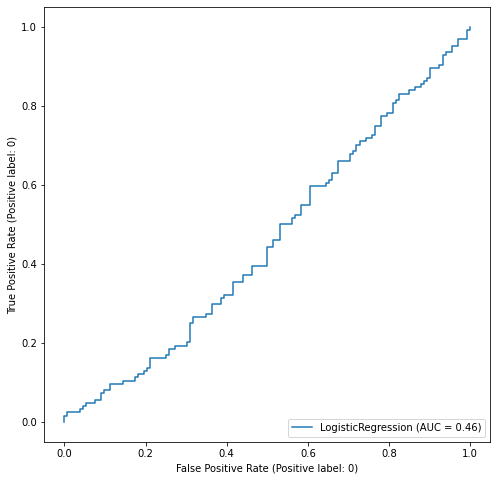

In [31]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(lr_model, X_test_w,y_test_w, pos_label=0, ax=plt.subplot());

En este caso la tasa de verdaderos positivos contra la de falsos positivos para diferentes puntos de corte es muy baja, es de 0.46.

**Informe**

In [32]:
results_df = pd.DataFrame()

report_LR = (classification_report(lr_bs.predict(X_test_w), y_test_w, target_names=['0','1']))
results_df = save_results(lr_model, X_test_w, y_test_w, 'LR', results_df)

print(report_LR)


              precision    recall  f1-score   support

           0       0.02      0.75      0.05         4
           1       0.99      0.52      0.68       252

    accuracy                           0.52       256
   macro avg       0.51      0.63      0.36       256
weighted avg       0.98      0.52      0.67       256



Podemos ver el acierto del modelo es coherente con el que hemos obtenido con la validación cruzada.

La clase 1 se obtiene resultados satifactible, en el que tiene una precisión de 99%, és decir, la mayoria de los individuos de la classe 1 se han clasificado como esta clase. Y todos los individuos que pertenencen en la esta clase sólo el 52% se han clasificado correctamente.

En el caso de la clase 0,los resultados obtenidos son horribles, tiene una precisión de 2% y todos los individuos que pertenencen en la esta clase el 75% se han clasificado correctamente.

También podemos observar que la media de los resultados de todas las clases son similares.

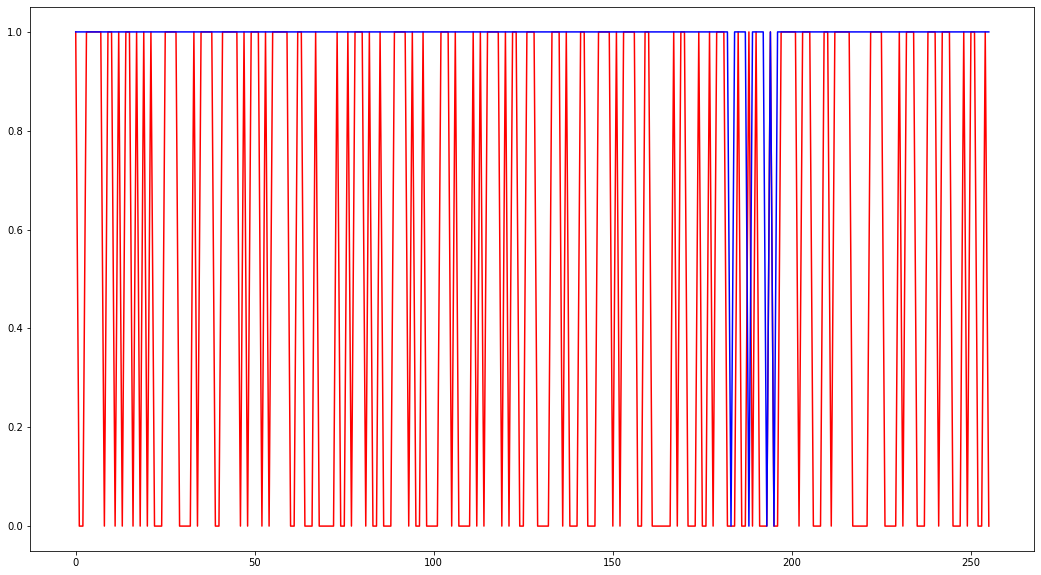

In [33]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:269],'r');
plt.plot(lr_bs.predict(X_test_w[:269,:]),'b');

Como hemos dicho anteriormente mayoria de la prediccion que pertence la clase 0 sonn incorrectos, ya que se predicen como si fuera de la classe 1, y el plot anterior nos permite observar visualmente.

#Apartado C

##MLP

En este apartado vamos a utilizar el modelo de la MLP

Primero exploraremos los hiperparámetros, para utilizar los que mejores resultados nos proporcionen. Una vez tengamos estos hiperparámetros, los aplicaremos a nuestro modelo y veremos que porcentaje de acierto obtenemos con el conjunto de test.

In [34]:
param = {'hidden_layer_sizes':[100, 200, 300], 
         'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'momentum': [0.95, 0.90, 0.85], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPRegressor(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs = BayesSearchCV(mlp,param,n_iter=niter, 
                        cv=TimeSeriesSplit(n_splits=CV, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlp_bs.fit(X_train_w, y_train_w);

In [35]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'momentum': 0.85, 'n_iter_no_change': 30}",-0.249926,1
12,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.85, 'n_iter_no_change': 30}",-0.249926,1
4,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 30}",-0.251250,3
9,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.252209,4
3,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.9, 'n_iter_no_change': 50}",-0.252356,5


Puede haber varios valores de hiperparametros que obtengan el mismo resultado, en ese caso elegiriamos cualquiera de entre ellos. 
Aplicaremos los hiperparámetros a nuestro modelo y veremos que porcentaje de acierto obtenemos con el conjunto de test.

In [36]:
act = mlp_bs.best_params_['activation']
alf = mlp_bs.best_params_['alpha']
hls = mlp_bs.best_params_['hidden_layer_sizes']
lRate = mlp_bs.best_params_['learning_rate']
lRateI = mlp_bs.best_params_['learning_rate_init']
mom = mlp_bs.best_params_['momentum']
niter = mlp_bs.best_params_['n_iter_no_change']

mlp =  MLPRegressor(max_iter=10000,early_stopping=True,random_state=0, activation=act, alpha=alf, hidden_layer_sizes=hls, learning_rate=lRate, learning_rate_init=lRateI, momentum=mom, n_iter_no_change=niter)
mlp_model = mlp.fit(X_train_w, y_train_w)


**Error de la validación cruzada**

In [37]:
print(np.mean(cross_val_score(mlp,X_train_w,y_train_w,cv=10)))

-0.14780977668709294


Todo y utilizando hiperparámetros obtenemos valores extramadamente mala de la media de error de la validación cruzada.  

**Error del test**

In [38]:
print(mlp_model.score(X_test_w,y_test_w))


-0.00892354188671085


Igual para el error de test

**Matriz de confusión MLP**

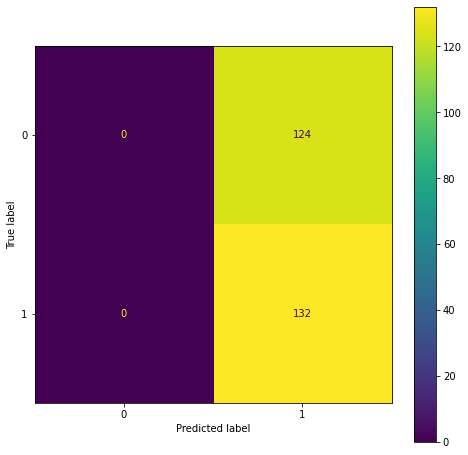

In [39]:
mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0, activation=act, alpha=alf, hidden_layer_sizes=hls, learning_rate=lRate, learning_rate_init=lRateI, momentum=mom, n_iter_no_change=niter)
mlp_model = mlp.fit(X_train_w, y_train_w)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_model, X_test_w,y_test_w, ax=plt.subplot());

En la matriz de confusión observamos que casi todos los variables se predice como 1(precio subirá el siguiente día), donde 121 de estas prediciones son falsos, es decir, pretenecen de la clase 0.

**Curva de ROC MLP**

El AUC proporciona una medida agregada del rendimiento en todos los umbrales de clasificación posibles. Podemos entender este valor como la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio.



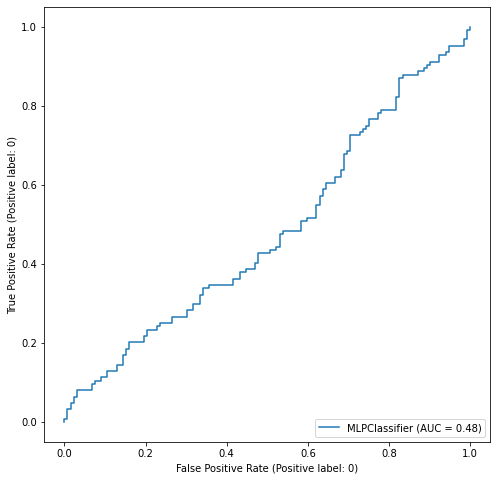

In [40]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(mlp_model, X_test_w,y_test_w, pos_label=0, ax=plt.subplot());

En este caso la tasa de verdaderos positivos contra la de falsos positivos para diferentes puntos de corte es muy baja, es de 0.48.

**Informe**

In [41]:
report_MLP = (classification_report(mlp_model.predict(X_test_w), y_test_w, target_names=['0','1']))
print(report_MLP)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.68       256

    accuracy                           0.52       256
   macro avg       0.50      0.26      0.34       256
weighted avg       1.00      0.52      0.68       256



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


La clase 1 tiene una precisión de 100%, es decir, la mayoria de los individuos que se han clasificado como 1 es realmente de esta clase. Y todos los individuos que es clasificado en esta clase el 52% pertencen realmente de la clase.

En el caso de la clase 0, la precisión es de 0%, ninguno de los individuos clasificado en este clase es realmente de esta clase. El 0% de esta clase se ha se han clasificado correctamente.

La diferencia entre el model de la regressión logística y MLP es, la regresión logística proporciona una medida de la incertidumbre en la ocurrencia de un resultado binario basado en un modelo lineal y la salida es binario. En cambio, el MLP es más complejo, se basa en productos punto entre ejemplos y pesos. en el que tiene la capacidad para resolver problemas que no son linealmente separables.

Los resultados obtenidos son bastante adecuado, ya que hemos observado en la matriz de correlación de la acción P de las 5 empresas, todo y que Apple, Micrsoft y AMD hay una correlación muy buena respecto la empresa Google, la empresa Intel la correlación respecto Google es demasiada baja, y por eso no se puede predecir de forma satisfactoria.

#APARTADO D

A continuación vamos a predecir si el volumen de negociación de las acciones de Google sube o no respecto al día anterior.

In [42]:
google_GAP = windows_train.squeeze()[:,:,-1][:,2]
y_train_w = ((google_GAP > X_train_w[:,8]).astype(int))
google_GAP = windows_test.squeeze()[:,:,-1][:,2]
y_test_w = ((google_GAP > X_test_w[:,8]).astype(int))

Renovamos las variables que queremos predecir.

##Regresión logística

In [43]:
lr = LogisticRegression(max_iter=1000)

En Regresión Logística si tenemos de hiperparámetros que exploraremos para utilizar los que mejores resultados nos proporcionen. Una vez tengamos estos hiperparámetros, los aplicaremos a nuestro modelo y veremos que porcentaje de acierto obtenemos con el conjunto de test.

In [44]:
param = {'penalty':['l2', 'none'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_bs =  BayesSearchCV(lr,param,cv=CV, n_iter=niter, n_jobs=-1, refit=True,random_state=0)
lr_bs.fit(X_train_w, y_train_w);

/usr/local/lib/python3.8/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [45]:
show_html = lambda html: display(HTML(html))
show_html(pd.DataFrame(lr_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'C': 1.9952623149688788, 'penalty': 'l2'}",0.637894,1
27,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.635894,2
25,"{'C': 125.89254117941663, 'penalty': 'l2'}",0.634905,3
28,"{'C': 1000.0, 'penalty': 'l2'}",0.631905,4
0,"{'C': 1.9952623149688788, 'penalty': 'none'}",0.629889,5


Puede haber varios valores de hiperparametros que obtengan el mismo resultado, en ese caso elegiriamos cualquiera de entre ellos. 

En este caso podemos ver como usando l2 como penalty y escogiendo un valor de C igual a 1.995, obtenemos los mejores resultados (acierto del 63,7%).

Coefs:
RangeIndex(start=0, stop=45, step=1)


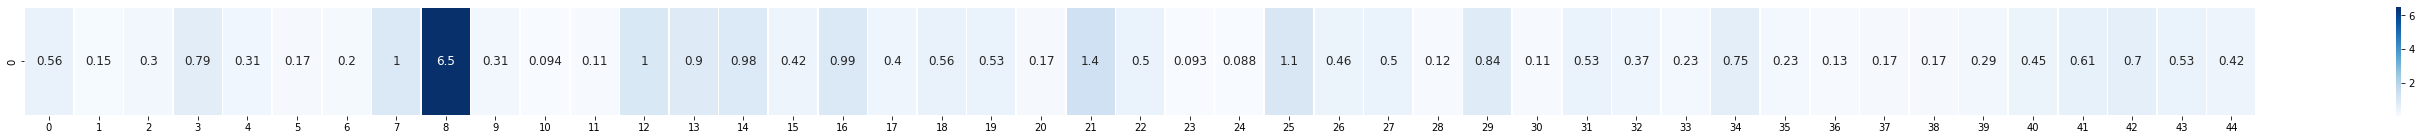

In [46]:
print('Coefs:')
coefs = pd.DataFrame(lr_bs.best_estimator_.coef_)
print(coefs.columns)
plt.figure(figsize=(50,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5, cbar=True, xticklabels=True, cmap='Blues', annot_kws={'size':12});

Esta matriz de coeficientes nos indica, para cada variable y clase, lo siguiente. Por cada aumento en una unidad en una de las variables, la clase incremente por el valor del coeficiente, mientras las otras variables se mantienen constantes.

In [47]:
c = lr_bs.best_params_['C']
lr = LogisticRegression(max_iter=1000, C=c)
lr_model = lr.fit(X_train_w, y_train_w)

**Error de la validación cruzada**

In [48]:
print(np.mean(cross_val_score(lr,X_train_w,y_train_w,cv=10)))

0.6358585858585858


Obtenemos una error de valdación cruzada de 63.5%, todos y que no es muy bueno comparando con el apartado B hemos mejorado.

**Error del test**

In [49]:
print(lr.score(X_test_w,y_test_w))

0.66015625


El error del test continua siendo muy alto.

**Matriz de confusión LR** 

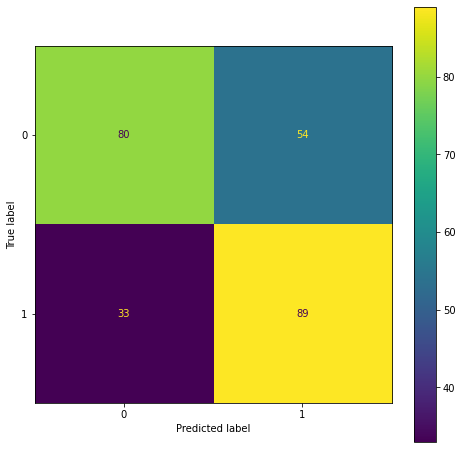

In [50]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_w,y_test_w, display_labels=['0', '1'], ax=plt.subplot());

Las matrices de confusión de cada uno de los modelos muestran resultados similares. Tiene el recuerdo más alto en el informe con la clase 0, predice 54 falsos positivos, y 33 falsos negativos.



**Curva de ROC LR**

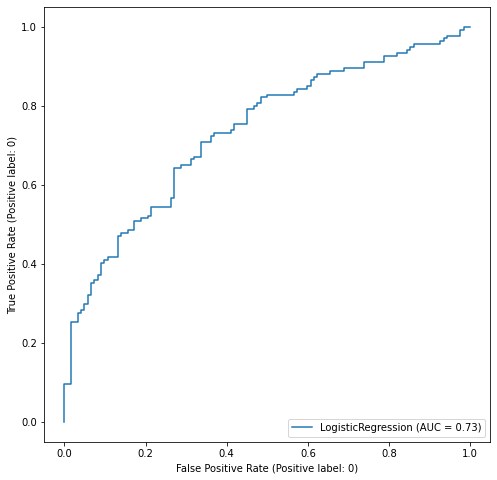

In [51]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(lr_model, X_test_w,y_test_w, pos_label=0, ax=plt.subplot());

En este caso la tasa de verdaderos positivos contra la de falsos positivos para diferentes puntos de corte es de 0.73.

**Informe**

In [52]:
report_LR = (classification_report(lr_bs.predict(X_test_w), y_test_w, target_names=['0','1']))
print(report_LR)


              precision    recall  f1-score   support

           0       0.60      0.71      0.65       113
           1       0.73      0.62      0.67       143

    accuracy                           0.66       256
   macro avg       0.66      0.67      0.66       256
weighted avg       0.67      0.66      0.66       256



La clase 1 tiene una precisión de 73%, es decir, hay un parte importante de los individuos que se han clasificado como 1 es realmente de esta clase. Y todos los individuos que es clasificado en esta clase el 62% pertencen realmente de la clase.

En el caso de la clase 0, la precisión es de 60%, es decir, hay un parte importante de los individuos que se han clasificado como 1 es realmente de esta clase. Y todos los individuos que es clasificado en esta clase el 71% pertencen realmente de la clase.

También podemos observar que la media de los resultados de todas las clases son similares igual que el weighted average pondera respecto a la proporción de cada clase.

##MLP

Primero exploraremos los hiperparámetros, para utilizar los que mejores resultados nos proporcionen. Una vez tengamos estos hiperparámetros, los aplicaremos a nuestro modelo y veremos que porcentaje de acierto obtenemos con el conjunto de test.

In [53]:
param = {'hidden_layer_sizes':[100, 200, 300], 
         'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'momentum': [0.95, 0.90, 0.85], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPRegressor(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs = BayesSearchCV(mlp,param,n_iter=niter, 
                        cv=TimeSeriesSplit(n_splits=CV, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlp_bs.fit(X_train_w, y_train_w);

mlp_bs


BayesSearchCV(cv=TimeSeriesSplit(gap=4, max_train_size=None, n_splits=5, test_size=None),
              estimator=MLPRegressor(early_stopping=True, max_iter=10000,
                                     random_state=0),
              n_iter=30, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'activation': ['relu', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85],
                             'n_iter_no_change': [30, 40, 50]})

In [54]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
14,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.95, 'n_iter_no_change': 50}",-0.249758,1
11,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 50}",-0.249909,2
24,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 30}",-0.249930,3
28,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 30}",-0.250122,4
13,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 30}",-0.250289,5


Aplicaremos los hiperparámetros a nuestro modelo y veremos que porcentaje de acierto obtenemos con el conjunto de test.

In [55]:
act = mlp_bs.best_params_['activation']
alf = mlp_bs.best_params_['alpha']
hls = mlp_bs.best_params_['hidden_layer_sizes']
lRate = mlp_bs.best_params_['learning_rate']
lRateI = mlp_bs.best_params_['learning_rate_init']
mom = mlp_bs.best_params_['momentum']
niter = mlp_bs.best_params_['n_iter_no_change']

mlp =  MLPRegressor(max_iter=10000,early_stopping=True,random_state=0, activation=act, alpha=alf, hidden_layer_sizes=hls, learning_rate=lRate, learning_rate_init=lRateI, momentum=mom, n_iter_no_change=niter)
mlp_model = mlp.fit(X_train_w, y_train_w)


**Error de la validación cruzada**

In [56]:
print(np.mean(cross_val_score(mlp,X_train_w,y_train_w,cv=10)))

0.05376963290442235


Utilizando hiperparámetros obtenemos valores la media de error de la validación cruzada 0.0538.

**Error del test**

In [57]:
print(mlp_model.score(X_test_w,y_test_w))


0.11641396540609839


Obtenemos un error de 0.116

**Matriz de confusión MLP**

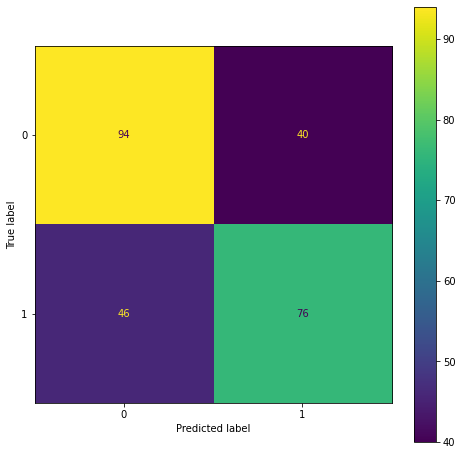

In [58]:
mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0, activation=act, alpha=alf, hidden_layer_sizes=hls, learning_rate=lRate, learning_rate_init=lRateI, momentum=mom, n_iter_no_change=niter)
mlp_model = mlp.fit(X_train_w, y_train_w)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_model, X_test_w,y_test_w, ax=plt.subplot());

**Curva de ROC MLP**

El AUC proporciona una medida agregada del rendimiento en todos los umbrales de clasificación posibles. Podemos entender este valor como la probabilidad de que el modelo clasifique un ejemplo positivo aleatorio más alto que un ejemplo negativo aleatorio.


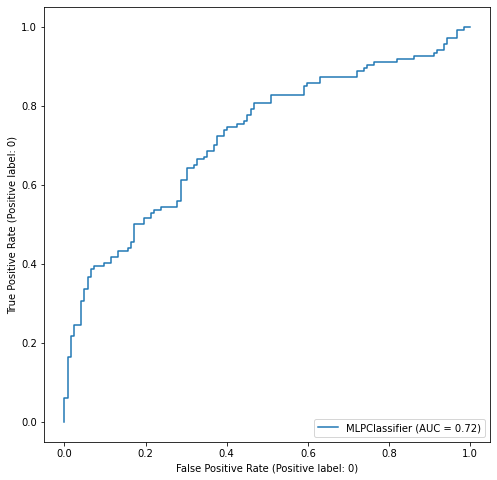

In [59]:
plt.figure(figsize=(8,8));
RocCurveDisplay.from_estimator(mlp_model, X_test_w,y_test_w, pos_label=0, ax=plt.subplot());

En este caso la tasa de verdaderos positivos contra la de falsos positivos para diferentes puntos de corte es muy baja, es de 0.72.

**Informe**

In [60]:
report_MLP = (classification_report(mlp_model.predict(X_test_w), y_test_w, target_names=['0','1']))
print(report_LR)


              precision    recall  f1-score   support

           0       0.60      0.71      0.65       113
           1       0.73      0.62      0.67       143

    accuracy                           0.66       256
   macro avg       0.66      0.67      0.66       256
weighted avg       0.67      0.66      0.66       256



La clase 1 tiene una precisión de 62%, es decir, hay un parte importante de los individuos que se han clasificado como 1 es realmente de esta clase. Y todos los individuos que es clasificado en esta clase el 66% pertencen realmente de la clase.

En el caso de la clase 0, la precisión es de 70%, es decir, hay un parte importante de los individuos que se han clasificado como 1 es realmente de esta clase. Y todos los individuos que es clasificado en esta clase el 67% pertencen realmente de la clase.

También podemos observar que la media de los resultados de todas las clases son similares igual que el weighted average pondera respecto a la proporción de cada clase.

Comprando con la otra variable obtenemos resultados mejor, el valor AUC de la regresión logistíca ha pasado de 0.46 a 0.73, y del MLP 0.48 a 0.72. 
Esto creo que es debido que la correlación de la acción GAP del Google es bastante alta con todas las resta de empresas.